# MNIST classification with QNNs

In this notebook you will build a quantum neural network (QNN) to classify a simplified version of MNIST with 
[Cirq](https://cirq.readthedocs.io/en/stable/) and TensorFlow Quantum (TFQ). The tutorial in general shows using a simple quantum neural network on a classical data problem. We here follow the approach used in the [Classification with Quantum Neural Networks on Near Term Processors](https://arxiv.org/pdf/1802.06002.pdf) paper by Edward Farhi and Hartmut Neven.

![](http://storage.rishit.tech/storage/TFUG-Mysuru-2020/classfication_with_qnn_paper.JPG)

> Note: This notebook is designed to be run in Google Colab if you want to run it locally or on a Jupyter notebook you 
would skip the code cells with the `Colab only` comment.

## Setup

### Install TensorFlow 2.x (Colab only)

In [ ]:
# Colab only
pip install -q tensorflow==2.1.0

### Install TensorFlow Quantum (Colab only)

In [ ]:
# Colab only
pip install -q tensorflow-quantum

## Imports

Now import TensorFlow and the module dependencies:

In [21]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections
import random

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

## Preprocessing the data

In the last tutorial you saw how to make a model to do hybrid quantum-classical binary classification. As this is meant to be an easy to follow and reproducoble tutorial, we will perform binary classification with MNIST. We will perform binary classification for this purpose with just two labels here `1` and `5` (Choosen as they look a lot different unlike something like 1 and 7)

### Load the raw data

Load the MNIST dataset distributed with Keras.

In [29]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

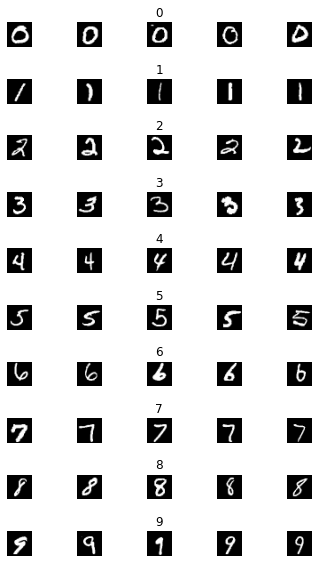

In [30]:
num_of_samples = []

cols = 5
num_classes = 10

fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 8))
fig.tight_layout()
for i in range(cols):
    for j in range(num_classes):
        x_selected = x_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected - 1)), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j))
            num_of_samples.append(len(x_selected))

In [31]:
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


Filter the dataset to keep just the 1s and 5s, remove the other classes. At the same time convert the label, `y`, to boolean: `True` for 1 and `False` for 5.

In [32]:
def filter_1_5(x, y):
    keep = (y == 1) | (y == 5)
    x, y = x[keep], y[keep]
    y = y == 1
    return x,y

In [33]:
x_train, y_train = filter_1_5(x_train, y_train)
x_test, y_test = filter_1_5(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12163
Number of filtered test examples: 2027


Display a random image

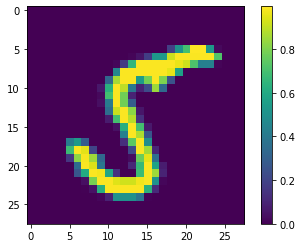

In [35]:
plt.imshow(x_train[random.randint(0,12000), :, :, 0])
plt.colorbar()

### Downscale the images

An image size of 28x28 is much too large for current quantum computers. Resize the image down to 4x4:

In [36]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

### Contradictory examples

"Learning to Distinguish Digits", filter the dataset to remove images that are labeled as belonging to both classes mentioned in [this paper](https://arxiv.org/pdf/1802.06002.pdf).

This is not a standard machine-learning procedure, but is included in the interest of following the paper.

In [37]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    for x,y in zip(xs,ys):
       mapping[tuple(x.flatten())].add(y)
    
    new_x = []
    new_y = []
    for x,y in zip(xs, ys):
      labels = mapping[tuple(x.flatten())]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(list(labels)[0])
      else:
          # Do not include images that match more than one label.
          pass
    
    num_1 = sum(1 for value in mapping.values() if True in value)
    num_5 = sum(1 for value in mapping.values() if False in value)
    num_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of 1s: ", num_1)
    print("Number of 5s: ", num_5)
    print("Number of contradictory images: ", num_both)
    print()
    print("Initial number of examples: ", len(xs))
    print("Remaining non-contradictory examples: ", len(new_x))
    
    return np.array(new_x), np.array(new_y)

In [38]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Number of unique images: 6588
Number of 1s:  2176
Number of 5s:  4626
Number of contradictory images:  214

Initial number of examples:  12163
Remaining non-contradictory examples:  7949


### Data as quantum circuits

We will represent each pixel with a qubit, with the state depending on the value of the pixel. The first step is to convert to a binary encoding.

In [39]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

The qubits at pixel indices with values that exceed a threshold, are rotated through an `X gate`

In [40]:
def convert_to_circuit(image):
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit

x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

Lets now visualize the circuit

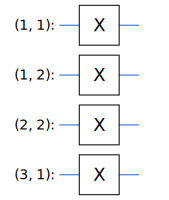

In [47]:
SVGCircuit(x_train_circ[random.randint(0,7949)])

Convert these Cirq circuits to tensors for `tfq`. This is made very easy with `convert_to_tensor()` in `tfq`.

## Quantum neural Network

[The paper](https://arxiv.org/pdf/1802.06002.pdf) propose using two qubit gates, with the readout qubit always acted upon. This is in a way similar to running a [Unitary RNN](https://arxiv.org/abs/1511.06464) in some ways.

### Build the model circuit

Each layer uses `n` instances of the same gate, with each of the data qubits acting on the readout qubit.

Start with a simple class that will add a layer of these gates to a circuit:

In [48]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

Build an example circuit layer:

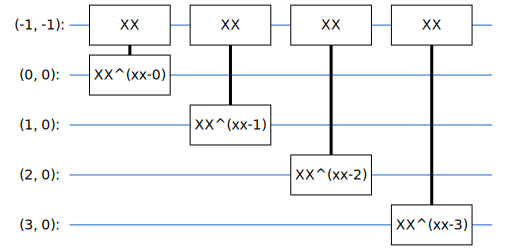

In [49]:
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(4,1),
                                   readout=cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

Now build a two-layered model, matching the data-circuit size, and include the preparation and readout operations.

In [50]:
def create_quantum_model():
    
    # Place data qunits on the grid
    data_qubits = cirq.GridQubit.rect(4, 4)  
    readout = cirq.GridQubit(-1, -1)
    circuit = cirq.Circuit()
    
    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)